# Iteration 0: Cell to cell type assignment. Cell label = 10275

In [ ]:
# Uncomment the line below to show all rows in a pandas dataframe
# import pandas as pd
# pd.set_option('display.max_rows', None)

### This is a notebook demonstrating what happens under the hood in the cell to cell type step in pciSeq

The focus here is on a particular cell (with label 10275) that has 29 gene counts but inside the first iteration the most likely class is the Zero class

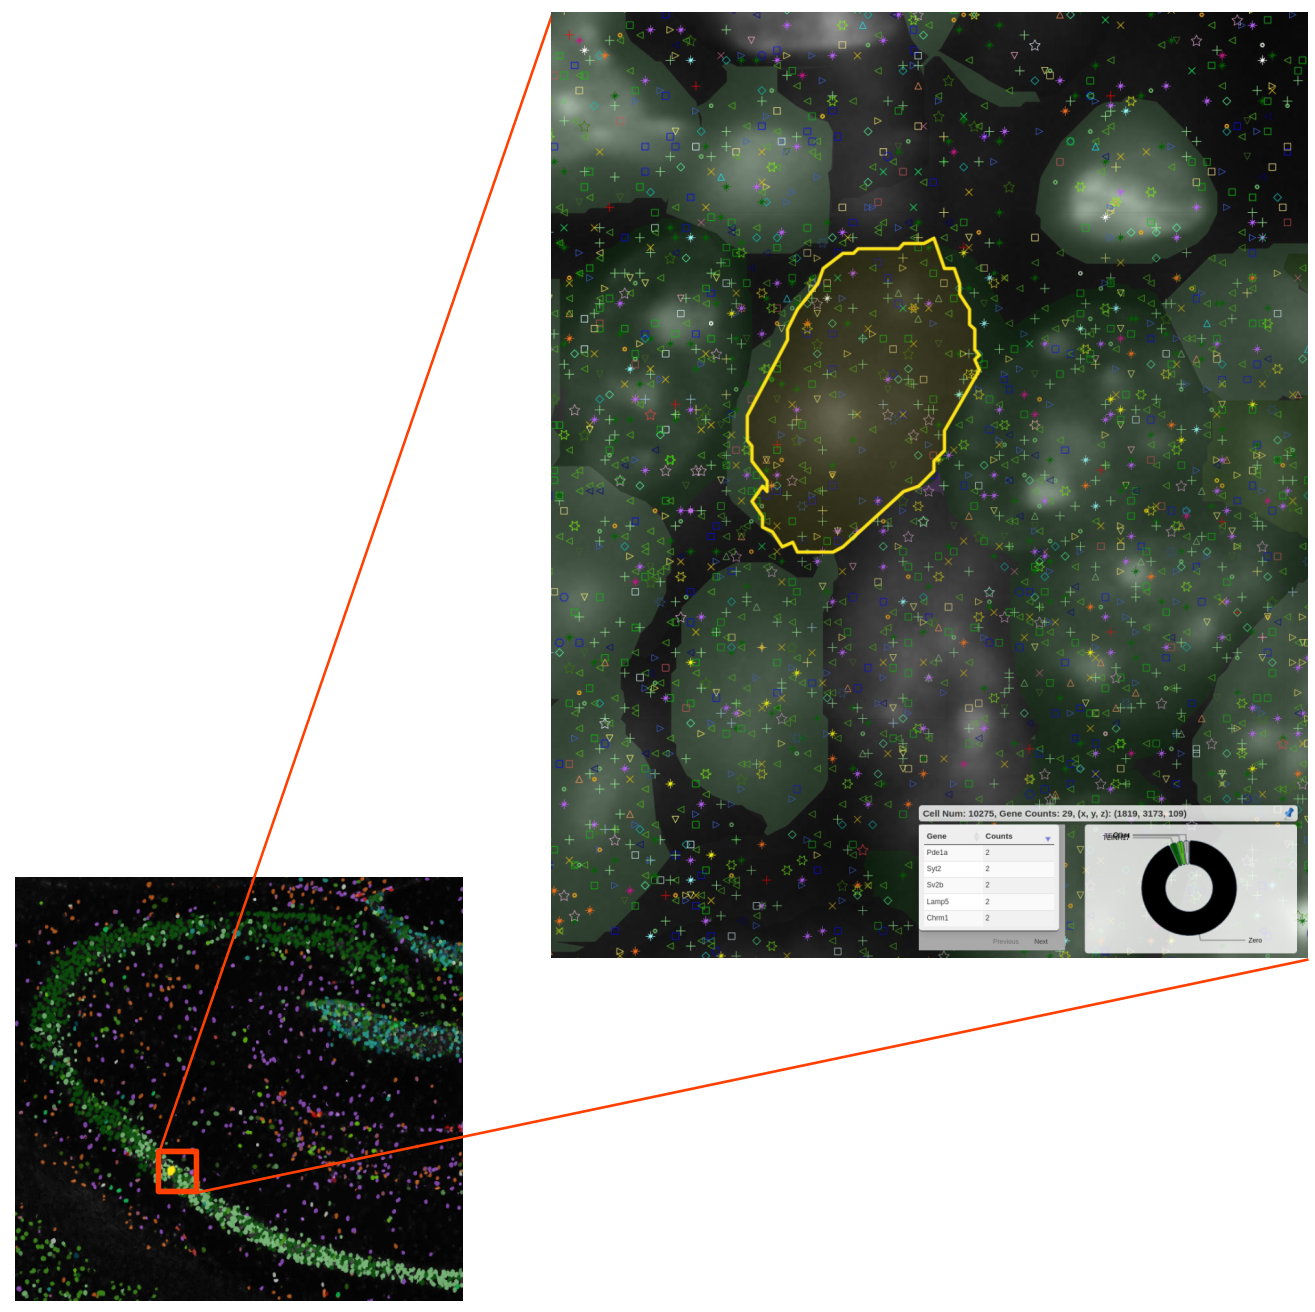

In [1]:
!pip install gdown

In [2]:
import pandas as pd
import numpy as np
import scipy
from scipy.special import softmax
import gdown

In [3]:
!pip install git+https://github.com/acycliq/pciSeq.git@dev_3d
import pciSeq

  Cloning https://github.com/acycliq/pciSeq.git (to revision dev_3d) to /tmp/pip-req-build-q29u9ppr
  Running command git clone --filter=blob:none --quiet https://github.com/acycliq/pciSeq.git /tmp/pip-req-build-q29u9ppr
  Running command git checkout -b dev_3d --track origin/dev_3d
  Switched to a new branch 'dev_3d'
  Branch 'dev_3d' set up to track remote branch 'dev_3d' from 'origin'.
  Resolved https://github.com/acycliq/pciSeq.git to commit 31fd7688f1f848d9e59931636ce39479614ea23d
  Preparing metadata (setup.py) ... done


In [4]:
file_id = "1wY1PUvAwk_S9MhKbCyB0HzH9oxNloP0M"
url = f"https://drive.google.com/uc?export=download&id={file_id}"
output = "pciSeq.pickle"

In [5]:
gdown.download(url, output, quiet=False)

Downloading...
From (original): https://drive.google.com/uc?export=download&id=1wY1PUvAwk_S9MhKbCyB0HzH9oxNloP0M
From (redirected): https://drive.google.com/uc?export=download&id=1wY1PUvAwk_S9MhKbCyB0HzH9oxNloP0M&confirm=t&uuid=f1ff1c17-1660-4913-8f58-61c5f3cf314a
To: /tmp/pciSeq/data/pciSeq.pickle
100%|██████████████████████████████████████| 1.79G/1.79G [03:21<00:00, 8.87MB/s]


'pciSeq.pickle'

In [6]:
obj = pd.read_pickle(output)

In [7]:
my_cell = 10275

In [8]:
# Set the hyperparameters
rSpot = 2.0               # Spread of the negative binomial
SpotReg = 0.1             # Spot regularization: Additive factor applied to the single cell data
inefficiency = 0.2        # multiplicative factor applied to the single cell data

In [9]:
# Another piece of information comes from the single cell data. For simplicity
# we are pulling here only the gene expressions for 'TEGLU23' (expected in CA3) 
# and 'TEGLU24', 'TEGLU21' (expected in CA3) 
my_class_definitions = obj.single_cell.mean_expression[
['TEGLU23', 'TEGLU24', 'TEGLU21', 'Zero']
]
my_class_definitions

class_name,TEGLU23,TEGLU24,TEGLU21,Zero
gene_name,,,,
Abi3bp,0.000000,0.006382,0.009615,0.0
Acly,0.247934,0.133039,0.519231,0.0
Adcyap1,0.138430,0.004418,0.221154,0.0
Adora2a,0.002066,0.001473,0.000000,0.0
Afp,0.000000,0.000000,0.000000,0.0
...,...,...,...,...
Vtn,0.004132,0.006382,0.000000,0.0
Wfs1,0.179752,1.669121,0.163462,0.0
Yjefn3,0.101240,0.110457,0.076923,0.0


### Part 1. Initialization

In [10]:
# To set the initial gene counts for any given cell we collect the gene reads inside the cell boundaries
# For cell 10275 these gene reads are the spots below
spots_10275 = obj.spots.data[obj.spots.data.label == my_cell]
spots_10275

,x,y,z,plane_id,label,gene_name,score
spot_id,,,,,,,
285482,1834.861938,3150.828857,100.140900,31,10275,C1ql3,0.6880
292285,1818.861938,3183.828857,109.783760,34,10275,Chrm1,0.5205
292298,1808.861938,3192.828857,103.355194,32,10275,Chrm1,0.7686
315009,1838.861938,3164.828857,103.355194,32,10275,Etv1,0.3965
322196,1801.861938,3188.828857,106.569473,33,10275,Gja1,0.8345
324002,1822.861938,3192.828857,103.355194,32,10275,Gpr83,0.9480
325282,1822.861938,3174.828857,103.355194,32,10275,Hs3st2,0.7754
326796,1825.861938,3169.828857,109.783760,34,10275,Id2,0.7430
328399,1830.861938,3146.828857,116.212334,36,10275,Igfbp4,0.8470


In [11]:
# Hence we aggregate per gene and we derive the gene counts
cgc = spots_10275.groupby('gene_name').size()
cgc

gene_name
C1ql3       1
Chrm1       2
Etv1        1
Gja1        1
Gpr83       1
Hs3st2      1
Id2         1
Igfbp4      1
Lamp5       2
Lypd1       1
Neurod6     1
Npnt        1
Nxph1       1
Pde1a       2
Prkca       1
Ptgds       1
Pthlh       1
Pvalb       1
Rgs10       1
Serpini1    1
Slc6a1      1
Sv2b        2
Syt2        2
Tac1        1
dtype: int64

In [12]:
# the cell has 29 reads inside its boundaries
cgc.sum()

29

In [13]:
# The cell gene counts introduced above contain only genes with gene reads > 0.
# We need however the full gene panel
cgc = cgc.reindex(obj.genes.gene_panel, fill_value=0)

In [14]:
# Note also that the eta (the random variable to model the gene inefficiency) is initialied as a vector of ones with lenght
# equal to the number of genes:
eta_bar = np.ones(obj.nG)

### Part 2. Cell to cell type

In [15]:
def negative_binomial_loglikelihood(x: np.ndarray, r: float, p: np.ndarray) -> np.ndarray:
    log_likelihood = x * np.log(p) + r * np.log(1 - p)

    return log_likelihood

In [16]:
# prepare now the data from the negative binomial
ScaledExp = my_class_definitions * inefficiency * eta_bar[:, None]
ScaledExp = ScaledExp + SpotReg
p = ScaledExp / (ScaledExp + rSpot)

In [17]:
# evaluate the loglikelihood
teglu_contr = negative_binomial_loglikelihood(cgc.values[:, None], rSpot, p.values)
teglu_contr.sum(axis=0)

array([-126.50855776, -120.44516175, -128.35122562, -118.93137379])

In [18]:
# some housekeeping, results look better in a dataframe
teglu_contr_df = pd.DataFrame(teglu_contr, columns=['TEGLU23', 'TEGLU24', 'TEGLU21', 'Zero']).set_index(obj.genes.gene_panel)
teglu_contr_df

,TEGLU23,TEGLU24,TEGLU21,Zero
Abi3bp,-0.097580,-0.098796,-0.099411,-0.09758
Acly,-0.144257,-0.122762,-0.194114,-0.09758
Adcyap1,-0.123776,-0.098422,-0.139267,-0.09758
Adora2a,-0.097974,-0.097861,-0.097580,-0.09758
Afp,-0.097580,-0.097580,-0.097580,-0.09758
...,...,...,...,...
Vtn,-0.098367,-0.098796,-0.097580,-0.09758
Wfs1,-0.131529,-0.392633,-0.128476,-0.09758
Yjefn3,-0.116772,-0.118510,-0.112179,-0.09758
Zcchc12,-0.135395,-0.107002,-0.101240,-0.09758


In [19]:
# Get the total loglikelihood
teglu_contr_df.sum(axis=0)

TEGLU23   -126.508558
TEGLU24   -120.445162
TEGLU21   -128.351226
Zero      -118.931374
dtype: float64

I seems that the Zero class has the highest loglikelihood

In [20]:
# Lets now compare the Zero class to TEGLU24 (second best)
my_df = teglu_contr_df[['TEGLU24', 'Zero']]

In [21]:
# calc the difference between the contributions
diff = teglu_contr_df['TEGLU24'] - teglu_contr_df['Zero']
my_df = my_df.assign(diff = diff)

In [22]:
# Top 5 genes that are cotributing most for the MFOL1 cell type
my_df.sort_values(by='diff', ascending=False).head(5)

,TEGLU24,Zero,diff
Sv2b,-4.062551,-6.186625,2.124075
Pde1a,-4.173733,-6.186625,2.012892
Chrm1,-4.291634,-6.186625,1.894991
Neurod6,-1.968118,-3.142103,1.173985
Prkca,-2.231030,-3.142103,0.911073


In [23]:
# Top 5 genes that are cotributing most for the Zero cell type
my_df.sort_values(by='diff', ascending=False).tail(5)

,TEGLU24,Zero,diff
Cplx2,-0.515379,-0.09758,-0.417799
Slc17a7,-0.927913,-0.09758,-0.830332
Cck,-1.287657,-0.09758,-1.190077
Snca,-1.295943,-0.09758,-1.198363
Nrgn,-1.386368,-0.09758,-1.288788
